# Setup / Data Loading

## Linking & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Install/Import required packages

!pip install --quiet networkx                   # Package for working with network based data syructures like Graphs
!pip install --quiet tf2_gnn                    # Package for implementing Graphs NNs for TF2

import numpy as np                              # for working with numerical arrays
from tqdm.notebook import tqdm                  # for fancy progress bar
import networkx as nx                           # for working with networks
import matplotlib.pyplot as plt                 # for matrix plots
from matplotlib import cm                       # for handling colourmaps for visualization
import random                                   # for enerating reandom numbers
import math                                     # modeule for mathematical formulae
import pandas as pd                             # pandas for working and manipulating data

#Import models for NN training and loading dataset
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.gnn import GNN, GNNInput

from tf2_gnn.layers.message_passing import *


In [ ]:
# Define a method to read the sdf file and create Graph representations
def read_sdf(file):
    with open(file, 'r') as rf:                                       # Open File to read
        content = rf.read()
    samples = content.split('$$$$')                                   # Split the lines at '$$$$' delimeter to seperate each sample (molecule data) from the file

    def parse_sample(s):
        lines = s.splitlines()                                        # Split each line
        links = []
        nodes = []
        label = 0
        for l in lines:                                               # Remove the the marker from the data and add corresponding Positive/Negative label
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):                                  # Identify if the line corresposnds to a node and if found, append to node list
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):                                   # Identify edges from and to each node and establish links
                lnk = l.split()
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1,
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label                          # Return created nodes, links and labels to wrapping function

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  # Return generated graph representations to calling function



# Load Train/Test dataset from drive and create a split for validation set
training_set = read_sdf('/content/drive/MyDrive/cisc/A6/train.sdf')
testing_set  = read_sdf('/content/drive/MyDrive/cisc/A6/test_x.sdf')
training_set, validation_set = train_test_split(training_set, test_size=0.25,)

print(training_set[0])


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

(['O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  8],
       [ 1, 11],
       [ 1, 12],
       [ 2, 11],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 4,  5],
       [ 4,  8],
       [ 5,  9],
       [ 6,  7],
       [ 6, 10],
       [ 7,  8],
       [ 7,  9],
       [10, 11]]), 0)


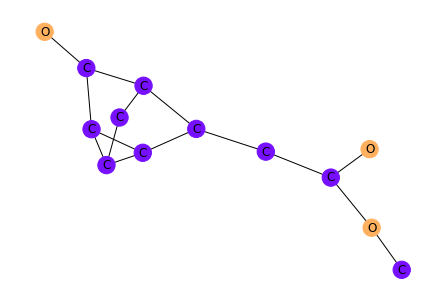

In [ ]:
# Visualize a sample from tehe loaded dataset

# Create a rainbow schemed colourmap with equally spaced samples between 0 and 1, Used for representing the colourspace of the nodes
colors = cm.rainbow(np.linspace(0, 1, 50))


# Define custom function to create a visualization
def visualize(sample):
    G=nx.Graph()                                            # Cretae an empty Graph object
    nodes = sample[0]                                       # Fetch nodes from the passed sample of training data
    edges = sample[1]                                       # Fetch edges/links from the passed sample of training data

    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)                                       # Add nodes to the graph
        labeldict[i]=n                                      # Add labels for atoms Carbon/Nitroen/Oxygen/Fluorine etc.
        node_color.append(colors[hash(n)%len(colors)])

    for e in edges:
        G.add_edge(e[0], e[1])                              # Add edges between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)     # Draw the Graph and plot it
    plt.show()

    return G                                                 # Return Graph

plt.clf()                                                    # Clear figure before plotting new one
visualize(training_set[0])                                   # Visulaise using defined function

## Data Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# Build vocabulary from training set
all_nodes = [s[0] for s in training_set]      # Get nodes from training set
tokenizer = Tokenizer(num_words=max_vocab)    # Generate tokens keep a maximum of 500 words, each with a max length of 100
tokenizer.fit_on_texts(all_nodes)             # Create an index for vocabulary based on frequency of each word/node in the graph

In [ ]:
random.seed(0)                    # Initialize random number generator with seed 0, ensures reproduceability

# Define a function to create a single mini-batch (inidividual molecule) from samples
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]                              # Fetch nodes from the sample graph
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)           # Create a sequence of integrers to represent the nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')          # Add paddings to ensure sequences are the same length
    max_nodes_len = np.shape(sample_nodes)[1]                           # Get max length of nodes for each sample
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]                            # Generate Edges for the links between each node in the sample
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]    # Generate the graph representation

    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)
    node_to_graph = np.reshape(node_to_graph, -1)
    return {                                                            # Return Graph as keys and values individual nodes, edges and the links between them
        'data': all_nodes,
        'edges': all_edges,
        'node2graph': node_to_graph,
    }, np.array([s[2] for s in samples])                                # Also return the labels for each


# Defining a method for generating a training/testing batch of 'n' minibatches
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):                              # Prepare individual minibatches and stick them together
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)                    # Combine 'batch_size' no. of minibatches
        if not repeat:
            break


In [ ]:
# Show one created batch of samples
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():        # Print the nodes, edges and their interlinks
        print(k)
        print(v)
        pass
    print('label', train_batch[1])            # Print the labels for the molecules in generated batch
    break

data
[3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 4 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
edges
[[  0   8]
 [  0  18]
 [  1   9]
 [  1  19]
 [  2  10]
 [  2  26]
 [  3  11]
 [  3  27]
 [  4  13]
 [  4  28]
 [  4  29]
 [  5  15]
 [  5  30]
 [  5  31]
 [  6   8]
 [  6  10]
 [  6  16]
 [  7   9]
 [  7  11]
 [  7  17]
 [  8  12]
 [  9  14]
 [ 10  20]
 [ 11  21]
 [ 12  13]
 [ 13  22]
 [ 14  15]
 [ 15  23]
 [ 16  22]
 [ 17  23]
 [ 18  20]
 [ 18  24]
 [ 19  21]
 [ 19  25]
 [ 26  32]
 [ 27  33]
 [ 32  34]
 [ 33  35]
 [ 34  36]
 [ 35  37]
 [ 36  37]
 [ 38  41]
 [ 38  45]
 [ 38  46]
 [ 39  47]
 [ 39  53]
 [ 40  50]
 [ 40  58]
 [ 40  59]
 [ 41  42]
 [ 41  43]
 [ 42  44]
 [ 42  47]
 [ 43  51]
 [ 44  48]
 [ 45  48]
 [ 46  52]
 [ 49  53]
 [ 49  54]
 [ 49  55]
 [ 50  56]
 [ 50  5

# Implementing RGCN Mechanism


## A.
Implementing the built-in RGCN mechanism discussed proposed by Schlichtkrull et al. (2017) with further fine tuning and more refining.

In [ ]:
from tf2_gnn.layers.message_passing import RGCN

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

node_embeddings = embeded
adjacency_lists=(edge,)

params = RGCN.get_default_hyperparameters()                        # Working with default_params defined in message_passing.RGCN
params["hidden_dim"] = 32
gnn_layer = RGCN(params)                                          # Define RGCN layer with imported params
gnn_out = gnn_layer(MessagePassingInput(node_embeddings, adjacency_lists))


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred
)
model.summary()


model.compile(                                                   # Default Optimizer to RMSProp
    loss='BinaryCrossentropy',                                   # Use Binary Cross Entrpy for loss calculation
    metrics='AUC'                                                # Use Area Under Curve for evaluating the model performance
)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']                   
                                                                                                  
 edges (InputLayer)             [(None, 2)]          0           []                               
                                                                                                  
 rgcn_5 (RGCN)                  (None, 32)           640         ['emb[0][0]',                    
                                                                  'edges[0][0]']            

In [ ]:
batch_size = 128                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5
147/147 [==============================] - 2s 15ms/step - loss: 0.1901 - auc: 0.6024 - val_loss: 0.1634 - val_auc: 0.6821
Epoch 2/5
147/147 [==============================] - 2s 14ms/step - loss: 0.1883 - auc: 0.6103 - val_loss: 0.1554 - val_auc: 0.5845
Epoch 3/5
147/147 [==============================] - 2s 14ms/step - loss: 0.1875 - auc: 0.6162 - val_loss: 0.1949 - val_auc: 0.6380
Epoch 4/5
147/147 [==============================] - 2s 14ms/step - loss: 0.1867 - auc: 0.6214 - val_loss: 0.2068 - val_auc: 0.6795
Epoch 5/5
147/147 [==============================] - 2s 15ms/step - loss: 0.1858 - auc: 0.6274 - val_loss: 0.1523 - val_auc: 0.7057


**Observation:**

The results are almost inline with the default params, likely since it also implements RGCN albeit with a different set of hyperparams.

Since this method of manually initialting a call to message_passing class is tedious, the next iterations will use similar method as the template.


## B.

Next Iter:

* Deeper GCN layers
* More hidden layers

To see if it makes any difference before further tuning other default parameters.


In [ ]:
# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGCN')         # Set Message Passing Style = RGCN
params["hidden_dim"] = 64                                         # Set dimension of hidden layer for convolutions to 64
params["num_layers"] = 8                                          # Set number of layers to 8
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred
)
model.summary()


model.compile(                                                   # Default Optimizer to RMSProp
    loss='BinaryCrossentropy',                                   # Use Binary Cross Entrpy for loss calculation
    metrics='AUC'                                                # Use Area Under Curve for evaluating the model performance
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['n2g[0][0]']                    
 da)                                                                                              
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']             

In [ ]:
batch_size = 128                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5
147/147 [==============================] - 99s 580ms/step - loss: 0.2817 - auc: 0.3991 - val_loss: 0.1820 - val_auc: 0.3937
Epoch 2/5
147/147 [==============================] - 94s 643ms/step - loss: 0.2063 - auc: 0.5596 - val_loss: 0.2327 - val_auc: 0.4980
Epoch 3/5
147/147 [==============================] - 88s 595ms/step - loss: 0.1966 - auc: 0.6156 - val_loss: 0.2082 - val_auc: 0.7035
Epoch 4/5
147/147 [==============================] - 92s 622ms/step - loss: 0.1950 - auc: 0.6216 - val_loss: 0.2054 - val_auc: 0.5629
Epoch 5/5
147/147 [==============================] - 95s 649ms/step - loss: 0.1903 - auc: 0.6414 - val_loss: 0.1985 - val_auc: 0.7082


## C.
Further changing the parameters:
* Added dropout
* hanged optimizer to Adam
* Changed initial_layer_activation
* Changed global_exchange_mode

In [ ]:
from tensorflow.keras.optimizers import Adam


# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGCN')         # Set Message Passing Style = RGCN
params["hidden_dim"] = 32                                         # Set dimension of hidden layer for convolutions to 64
params["num_layers"] = 6                                          # Set number of layers to 8
params["global_exchange_mode"] = "mlp"
params["initial_node_representation_activation"] = "relu"
params["layer_input_dropout_rate"] = 0.2
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
model = Model(

    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred
)
model.summary()


model.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),          # Optimizer set to Adam with AmsGrad
    loss='BinaryCrossentropy',
    metrics='AUC'
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_7 (TFOpLamb  ()                  0           ['n2g[0][0]']                    
 da)                                                                                              
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']             

In [ ]:
batch_size = 128                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

# Implementing GINConv

## A.
Xu et al. (2018) [1] proposed a method to learn non-linear representations during aggregation which helps further express the interaction between neighbouring nodes.

[1] Xu, K., Hu, W., Leskovec, J., & Jegelka, S. (2018). How powerful are graph neural networks?. arXiv preprint arXiv:1810.00826.

Ref [https://towardsdatascience.com/recent-advances-in-graph-convolutional-network-gcn-9166b27969e5]

* Default Implementation to see base performance

In [1]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGIN')         # Set Message Passing Style = GINConv named as RGIN in the library
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgin = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GIN"
)
mgin.summary()

# Same as before
mgin.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

NameError: name 'keras' is not defined

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgin.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

In [ ]:
# Generate submission from predictions since training results look promising
# Predict the labels on testing dataset to find how good the model performs.
# y_pred = mgin.predict(
#     gen_batch(testing_set, batch_size=16, shuffle=False)                     #  Create slices of the Test dataset to generate batches for prediction
# )
# y_pred = np.reshape(y_pred, -1)                                              # Reshape the data to 1D, also to use for generating csv submissions

# submission = pd.DataFrame({'label':y_pred})
# submission.index.name = 'id'
# submission.to_csv('/content/drive/MyDrive/cisc/A6/S-GIN.csv')

**Observation**:

Higher AUC as compared to previous iterations.

With more training and further tuning, it could be more promising.

However, in the interest of time, the number of epochs are kept low to demonstarte a proof of concept.

## B.
Further Tuning GINConv

* More layers
* Dropout
* Changed no. of MLP for GIN
* Changed Dropout for GLobal_exchange

In [ ]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGIN')         # Set Message Passing Style = GINConv named as RGIN in the library
params["hidden_dim"] = 64
params["num_layers"] = 6                                          # Changing hidden dim and num_layer
params["num_edge_MLP_hidden_layers"] = 2                          # Changing number of hidden layers for GIN MLP
params["layer_input_dropout_rate"] = 0.25                         # Added dropout to input layer
params["global_exchange_dropout_rate"] = 0.25                     # Increasing dropout for global_exchg
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgin2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GIN-2"
)
mgin2.summary()

# Same as before
mgin2.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgin2.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

# Implementing GAT




## A.
In the paper [2], the authors create a novel architecture that utilizes masked-self-attention layers to imrpove the performance of normal GCNs. This is done by adding an attention coeffecient during aggregation which helps attend over the features of neighboring nodes.

[2] Veličković, P., Cucurull, G., Casanova, A., Romero, A., Lio, P., & Bengio, Y. (2017). Graph attention networks. arXiv preprint arXiv:1710.10903.

In [ ]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGAT')         # Set Message Passing Style = GAT based GCN named as RGAT in the library
params["hidden_dim"] = 32
params["num_heads"] = 2                                           # GAT requires the hidden_dim be a multiple of num_heads. Default = 3
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgat = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GAT-GCN"
)
mgat.summary()

# Same as before
mgat.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

Model: "GAT-GCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_25 (TFOpLam  ()                  0           ['n2g[0][0]']                    
 bda)                                                                                             
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']             

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgat.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib

294/294 [==============================] - 28s 79ms/step - loss: 0.3057 - auc: 0.4314 - val_loss: 0.2314 - val_auc: 0.6570
Epoch 2/5
294/294 [==============================] - 24s 81ms/step - loss: 0.1954 - auc: 0.6091 - val_loss: 0.1765 - val_auc: 0.7027
Epoch 3/5
294/294 [==============================] - 24s 81ms/step - loss: 0.1874 - auc: 0.6551 - val_loss: 0.2056 - val_auc: 0.6414
Epoch 4/5
294/294 [==============================] - 23s 79ms/step - loss: 0.1824 - auc: 0.6846 - val_loss: 0.2049 - val_auc: 0.6784
Epoch 5/5
294/294 [==============================] - 23s 79ms/step - loss: 0.1827 - auc: 0.6806 - val_loss: 0.1845 - val_auc: 0.7147


**Observation**

Very Similar results to base run of GINConv, and val_loss also follows similar trend, albeit the loss is less.





## B.

Adding fine tuning of paramaters to GAT to see imrpovement in performance/effecient training

In [ ]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGAT')         # Set Message Passing Style = GAT based GCN named as RGAT in the library
params["hidden_dim"] = 40
params["num_heads"] = 4                                           # GAT requires the hidden_dim be a multiple of num_heads. Default = 3
params["num_layers"] = 6
params["layer_input_dropout_rate"] = 0.25
params["initial_node_representation_activation"] = "relu"
params["dense_intermediate_layer_activation"] = "relu"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgat2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GAT2-GCN"
)
mgat2.summary()

# Same as before
mgat2.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

Model: "GAT2-GCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_32 (TFOpLam  ()                  0           ['n2g[0][0]']                    
 bda)                                                                                             
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']            

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgat2.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_5_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_5_grad/gradients/grad_ys_0_values:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_5_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_5_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_5_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_5_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a l

294/294 [==============================] - 64s 188ms/step - loss: 0.2862 - auc: 0.4902 - val_loss: 0.2679 - val_auc: 0.6849
Epoch 2/5
294/294 [==============================] - 55s 186ms/step - loss: 0.1977 - auc: 0.5960 - val_loss: 0.1736 - val_auc: 0.7394
Epoch 3/5
294/294 [==============================] - 60s 203ms/step - loss: 0.1913 - auc: 0.6415 - val_loss: 0.1984 - val_auc: 0.6455
Epoch 4/5
294/294 [==============================] - 53s 181ms/step - loss: 0.1868 - auc: 0.6689 - val_loss: 0.2185 - val_auc: 0.6427
Epoch 5/5
294/294 [==============================] - 53s 181ms/step - loss: 0.1837 - auc: 0.6822 - val_loss: 0.1775 - val_auc: 0.7281


In [ ]:
# Generate submission from predictions since training results look promising
# Predict the labels on testing dataset to find how good the model performs.
y_pred = mgat2.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)                     #  Create slices of the Test dataset to generate batches for prediction
)
y_pred = np.reshape(y_pred, -1)                                              # Reshape the data to 1D, also to use for generating csv submissions

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/cisc/A6/S-GAT2.csv')

771/771 [==============================] - 12s 15ms/step


**Observation**

The finetuned GAT model has one of the lowest val_loss and a really good auc score.
This confirms the claims authors make in the paper about GATs adding more performance to base GCNs.

# Implementing Extended GCN with FiLM

## A.

This approach is based on [3]. The authors further the aggregation mechanism for GCNs by applying feature-wise Linear Motion which involves applying a transformation to incoming messages.

[3] Brockschmidt, M. (2020, November). Gnn-film: Graph neural networks with feature-wise linear modulation. In International Conference on Machine Learning (pp. 1144-1152). PMLR.

In [ ]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='GNN_FiLM')         # Set Message Passing Style = GAT based GCN named as RGAT in the library
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgfilm = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GCN-FILM"
)
mgfilm.summary()

# Same as before
mgfilm.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

Model: "GCN-FILM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_38 (TFOpLam  ()                  0           ['n2g[0][0]']                    
 bda)                                                                                             
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']            

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgfilm.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/pyth

294/294 [==============================] - 26s 79ms/step - loss: 0.2787 - auc: 0.4623 - val_loss: 0.2088 - val_auc: 0.6879
Epoch 2/5
294/294 [==============================] - 24s 82ms/step - loss: 0.1933 - auc: 0.6246 - val_loss: 0.1788 - val_auc: 0.7040
Epoch 3/5
294/294 [==============================] - 23s 80ms/step - loss: 0.1902 - auc: 0.6434 - val_loss: 0.1954 - val_auc: 0.6173
Epoch 4/5
294/294 [==============================] - 24s 81ms/step - loss: 0.1855 - auc: 0.6810 - val_loss: 0.1767 - val_auc: 0.7262
Epoch 5/5
294/294 [==============================] - 22s 76ms/step - loss: 0.1835 - auc: 0.6930 - val_loss: 0.1927 - val_auc: 0.7367


In [ ]:
# Generate submission from predictions since training results look promising
# Predict the labels on testing dataset to find how good the model performs.
# y_pred = mgfilm.predict(
#     gen_batch(testing_set, batch_size=16, shuffle=False)                     #  Create slices of the Test dataset to generate batches for prediction
# )
# y_pred = np.reshape(y_pred, -1)                                              # Reshape the data to 1D, also to use for generating csv submissions

# submission = pd.DataFrame({'label':y_pred})
# submission.index.name = 'id'
# submission.to_csv('/content/drive/MyDrive/cisc/A6/S-GF.csv')

771/771 [==============================] - 6s 8ms/step


**Observation**:

The previous run was really promising and forecasts massive improvements in model performance if the hyperparams are properly tuned.

## B.


The authors suggest using extensive search to find best model params, but I am not sure how to do that.

This iteration involves among other things:

* Increasing hidden layer for FiLM
* Increasing edge MLP layers

In [ ]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='GNN_FiLM')         # Set Message Passing Style = GAT based GCN named as RGAT in the library
params["hidden_dim"] = 48
params["num_layers"] = 6
params["layer_input_dropout_rate"] = 0.25
params["initial_node_representation_activation"] = "relu"             # Changing activation for node_representation layer
params["dense_intermediate_layer_activation"] = "relu"                # Changing activation for intermediate layers
params["num_edge_MLP_hidden_layers"] = 2                              # FiLM specific MLP hidden layers increased
params["film_parameter_MLP_hidden_layers"] = 1                        # Added MLP for FiLM params
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgfilm2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GCN-FILM2"
)
mgfilm2.summary()

# Same as before
mgfilm2.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

Model: "GCN-FILM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_41 (TFOpLam  ()                  0           ['n2g[0][0]']                    
 bda)                                                                                             
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']            

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(training_set) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(validation_set) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgfilm2.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(validation_set, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5
294/294 [==============================] - 61s 209ms/step - loss: 0.1680 - auc: 0.7690 - val_loss: 0.1585 - val_auc: 0.7887
Epoch 2/5
294/294 [==============================] - 62s 210ms/step - loss: 0.1807 - auc: 0.7511 - val_loss: 0.1811 - val_auc: 0.6993
Epoch 3/5
294/294 [==============================] - 63s 213ms/step - loss: 0.1716 - auc: 0.7460 - val_loss: 0.1608 - val_auc: 0.7639
Epoch 4/5
294/294 [==============================] - 61s 208ms/step - loss: 0.1709 - auc: 0.7562 - val_loss: 0.1878 - val_auc: 0.7515
Epoch 5/5
294/294 [==============================] - 66s 224ms/step - loss: 0.1693 - auc: 0.7599 - val_loss: 0.1620 - val_auc: 0.7792


**Observation**

While the AUC score is slightly lesser than that of GAT-2, the val_loss is also really low which sounds promisinng.

The trend suggests training for more epochs would yield better results.

# Upsampling Data



The data is unbalanced, and would benefit from increased positive samples for training.

Hence in this block we use the RandomOverSampler to UpSample the minotrity samples and reframe it into the required format for batch generation (as before)

## New PreProcessing

In [ ]:
# Load dataset again in a anew object to prevent overrighting the old one, required for comparison
ts2 = read_sdf('/content/drive/MyDrive/cisc/A6/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
# The RandomOverSampler doesn't directly work with graphs or lists containing graph elements.
# Hence, the following is required to generate a dataframe for working on the data.
# This is just a work around that I found simple to understand, there are other ways to do it.
ln = []
le = []
ll = []
for m in ts2:
  ln.append(m[0])
  le.append(m[1])
  ll.append(m[2])

frame = pd.DataFrame(list(zip(ln, le, ll)),
               columns =['Node', 'Edge', "labels"])

X = frame.drop("labels", axis = 1)
y = frame["labels"]

In [ ]:
# Upsample Data to increase the number of samples and reduce the large unbalance in the input class

from imblearn.over_sampling import RandomOverSampler
ros =  RandomOverSampler(sampling_strategy='minority')  # Use the upsampling method to upsample only minority values

X_up, y_up = ros.fit_resample(X, y)                     # Fit the UpSampling method on the data X with Y as labels and generate Upsampled set

X.shape, y.shape, X_up.shape, y_up.shape                # Show the shape of old data vs new data

((25024, 2), (25024,), (47612, 2), (47612,))

In [ ]:
# Since the data we upsampled is a pandas series type, we need to go back to original form
# to be able to use previously defined method on the newly generated dataset

# Custom method to fetch elements from series and pass them into the new dataset (list)
def assembler(i):
  a = X_up["Node"][i]
  b = X_up["Edge"][i]
  c = y_up[i]
  return a, np.array(b), c

# Generate list representation of the dataset in the same format as before i.e [nodes, edges, labels]
tsnew = []
for i in range (len(X_up)):
  tsnew.append(assembler(i))

In [ ]:
# Just a comparison code of the ratio of samples in old dataset vs new dataset
# Archaic method to count the elements with positive samples and negative samples and compare the length of list
# Its an old spell, but quite effective ;P

la = []
lb = []
for i in training_set:
  if i[2] == 1:
    la.append(i[2])
  else:
    lb.append(i[2])

print("Old class balance= ", len(la), len(lb))

for i in tsnew:
  if i[2] == 1:
    la.append(i[2])
  else:
    lb.append(i[2])

print("New class balance= ", len(la), len(lb))


Old class balance=  914 17854
New class balance=  24720 41660


In [ ]:
# Generate Training and validation sets from new Dataset
tset_new, vset_new = train_test_split(tsnew, test_size=0.25,)

In [ ]:
max_vocab = 500
max_len = 100

# Build vocabulary from training set
all_nodes2 = [s[0] for s in tset_new]      # Get nodes from training set
tokenizer2 = Tokenizer(num_words=max_vocab)    # Generate tokens keep a maximum of 500 words, each with a max length of 100
tokenizer2.fit_on_texts(all_nodes2)             # Create an index for vocabulary based on frequency of each word/node in the graph

## Implementing the Model Again, with new dataset

Utilizing the GAT-2 model with modified params with the new dataset since it yielded the most stable and high quality result in the previous iterations.

This implementation is the same as before, except it is run on the newly generated dataset.

In [ ]:

# Create input tensors to pass to the GNN. (Added names to better analyze the output in Model Summary)
data = keras.Input(batch_shape=(None,), name = 'data')
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32, name = 'edges')
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32, name = 'n2g')
embeded = Embedding(tokenizer2.num_words, 20, name = 'emb')(data)


# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Defining the tuple to pass as an input to the GNN
gnn_input = GNNInput(
    node_features=embeded,                                        # The initial node features are the input embeddings
    adjacency_lists=(edge,),                                      # The adjacency list is teh tensor of edges
    node_to_graph_map=node2graph,                                 # Pass the node to graph map
    num_graphs=num_graph,                                         # The input works with given no. of samples
)


params = GNN.get_default_hyperparameters(mp_style='RGAT')         # Set Message Passing Style = GAT based GCN named as RGAT in the library
params["hidden_dim"] = 20
params["num_heads"] = 4                                           # GAT requires the hidden_dim be a multiple of num_heads. Default = 3
params["num_layers"] = 6
params["layer_input_dropout_rate"] = 0.25
params["initial_node_representation_activation"] = "relu"
params["dense_intermediate_layer_activation"] = "relu"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(data=gnn_out, segment_ids=node2graph)          # Calculate the segment mean to use for prediction

pred = Dense(1, activation='sigmoid')(avg)                        # Output layer for predictions

# Definng the model for training
mgatup = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name = "GATUp-GCN"
)
mgatup.summary()

# Same as before
mgatup.compile(
    optimizer = Adam(learning_rate=0.001, amsgrad = True),
    loss='BinaryCrossentropy',
    metrics='AUC'
)

Model: "GATUp-GCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 n2g (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 data (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_43 (TFOpLam  ()                  0           ['n2g[0][0]']                    
 bda)                                                                                             
                                                                                                  
 emb (Embedding)                (None, 20)           10000       ['data[0][0]']           

In [ ]:
batch_size = 64                                                                 # Size of inidividual mini-batch (no. of compunds to use for each minibatch)
ep = 5                                                                         # No. of Epochs
num_batchs = math.ceil(len(tset_new) / batch_size)                          # Total no. of batches for training based on total size and size of inidividual mini batch
num_batchs_validation = math.ceil(len(vset_new) / batch_size)             # Total no. of batches for validation


# Fit the model to begin training
mgatup.fit(
    gen_batch(tset_new, batch_size=batch_size, repeat=True),                # Generate batches for training based on b_size and passing the training set
    steps_per_epoch=num_batchs,                                                 # Each epoch has same steps and the no. of batches
    epochs=ep,
    validation_data=gen_batch(vset_new, batch_size=16, repeat=True),      # Generate batches for validation
    validation_steps=num_batchs_validation,                                     # Steps for validation
)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_5_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_5_grad/gradients/grad_ys_0_values:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_5_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_5_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_5_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_5_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a l

558/558 [==============================] - 141s 235ms/step - loss: 0.6533 - auc: 0.6485 - val_loss: 0.6446 - val_auc: 0.6913
Epoch 2/5
558/558 [==============================] - 118s 212ms/step - loss: 0.6152 - auc: 0.7124 - val_loss: 0.6108 - val_auc: 0.7460
Epoch 3/5
558/558 [==============================] - 118s 212ms/step - loss: 0.5972 - auc: 0.7379 - val_loss: 0.5881 - val_auc: 0.7549
Epoch 4/5
558/558 [==============================] - 125s 224ms/step - loss: 0.5864 - auc: 0.7538 - val_loss: 0.6042 - val_auc: 0.7589
Epoch 5/5
558/558 [==============================] - 119s 212ms/step - loss: 0.5783 - auc: 0.7645 - val_loss: 0.5636 - val_auc: 0.7962


In [ ]:
# Generate submission from predictions since training results look promising
# Predict the labels on testing dataset to find how good the model performs.
y_pred = mgatup.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)                     #  Create slices of the Test dataset to generate batches for prediction
)
y_pred = np.reshape(y_pred, -1)                                              # Reshape the data to 1D, also to use for generating csv submissions

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/cisc/A6/S-GATUP.csv')

771/771 [==============================] - 14s 17ms/step


**Observation**

The updsampling clearly boosted the performance by a significant margin as seen on the leaderboard.

This result was achieved at just 5 epochs. Calibrating the params more and training for longer would get even better results.